In [1]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [2]:
data=pd.read_csv('toronto.csv')
data.replace(9999,np.nan,inplace=True)
data.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    for j in range(len(data.columns)):
        if np.isnan(data.iat[i,j]):
            if i==0:
                data.iloc[i,j]=data.iat[i+1,j]
            elif i==len(data)-1:
                data.iloc[i,j]=data.iat[i-1,j]
            else:
                data.iloc[i,j]=np.nanmean([data.iat[i-1,j],data.iat[i+1,j]])

In [3]:
# data.fillna(np.mean(data),inplace=True)

In [4]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,-6.2,-13.2,58.0,25.0,43.0,16.1,100.68,-16.0,3.0,15.0,18.0,19.0,6.0
1,-6.0,-13.7,55.0,24.0,41.0,16.1,100.59,-16.0,2.0,14.0,16.0,19.0,7.0
2,-6.2,-13.3,57.0,24.0,45.0,16.1,100.56,-16.0,1.0,10.0,11.0,22.0,7.0
3,-6.0,-12.0,63.0,24.0,32.0,16.1,100.58,-15.0,1.0,10.0,11.0,21.0,7.0
4,-6.0,-12.2,62.0,24.0,35.0,16.1,100.50,-15.0,2.0,11.0,13.0,19.0,7.0


In [5]:
dataset=pd.DataFrame(data,columns=data.columns[:])
split=round(0.90*len(dataset))
data1=dataset.iloc[:split].copy()
test_set=dataset.iloc[split:].copy()

In [6]:
scaler = preprocessing.MinMaxScaler() 
data1 = scaler.fit_transform(data1)
test_set1=scaler.transform(test_set)
# dataset.loc[:,:] = scaled_values

In [7]:
# test_set

In [8]:
# data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data1)-seq_len
y=len(test_set)-seq_len
sequences = [np.asarray(data1[t:t+seq_len]) for t in range(x)]
test_seq=[np.asarray(test_set[t:t+seq_len]) for t in range(y)]
test_seq1=[np.asarray(test_set1[t:t+seq_len]) for t in range(y)]

In [9]:
type(test_seq)

list

In [10]:
seq=torch.FloatTensor(np.asarray(sequences))
test_seq=torch.FloatTensor(np.asarray(test_seq))
test_seq1=torch.FloatTensor(test_seq1)

In [11]:
test_seq.shape

torch.Size([845, 31, 13])

In [12]:
split_row=round(0.80*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1:]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1:]
x_test_set=test_seq1[:,:-1]
y_test_set=test_seq[:,-1:]

In [13]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1:])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [14]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    batch_y = batch_y.transpose(0,1)
    
    return batch_x, batch_y

In [15]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [16]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [17]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'toronto.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [18]:
def load_model(city, model, path='./'):
    
    # file name and path 
    filename = path + '{}.pt'.format(city)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

Training model for 40 epoch
Epoch 1: Loss = 0.02875476
Validation: Loss = 0.01399143
Epoch 2: Loss = 0.00950872
Validation: Loss = 0.00870981
Epoch 3: Loss = 0.00730255
Validation: Loss = 0.00699581
Epoch 4: Loss = 0.00620711
Validation: Loss = 0.00608072
Epoch 5: Loss = 0.00570191
Validation: Loss = 0.00573658
Epoch 6: Loss = 0.00545097
Validation: Loss = 0.00545945
Epoch 7: Loss = 0.00528087
Validation: Loss = 0.00507464
Epoch 8: Loss = 0.00515113
Validation: Loss = 0.00491360
Epoch 9: Loss = 0.00501603
Validation: Loss = 0.00487238
Epoch 10: Loss = 0.00501465
Validation: Loss = 0.00479590
Epoch 11: Loss = 0.00494306
Validation: Loss = 0.00462293
Epoch 12: Loss = 0.00489777
Validation: Loss = 0.00462129
Epoch 13: Loss = 0.00488167
Validation: Loss = 0.00462213
Epoch 14: Loss = 0.00483084
Validation: Loss = 0.00447974
Epoch 15: Loss = 0.00482029
Validation: Loss = 0.00440030
Epoch 16: Loss = 0.00479621
Validation: Loss = 0.00450575
Epoch 17: Loss = 0.00478776
Validation: Loss = 0.0044

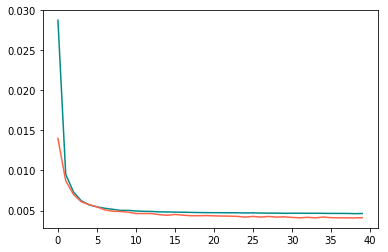

In [19]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 40 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x_shuffled = x_train_set[idx]
    y_shuffled = y_train_set[idx]
    
    train_loss=train(lstm,x_shuffled,y_shuffled,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [21]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

In [22]:
lstm=load_model('toronto',lstm)

In [23]:
def predict_one_hour(model,x_valid_set,input_size,num_steps,scaler,y_valid_set,loss_fn):
    total_loss=0
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
#         print(y_pred.shape)
        predictions[i]=torch.FloatTensor(scaler.inverse_transform(y_pred[0].data)[:,-1])
        loss=loss_fn(y_pred.squeeze(1),y_valid_set[i])
        total_loss+=loss
    return predictions,total_loss/num_steps

In [24]:
loss_fn=nn.MSELoss()
one_step_predictions,loss = predict_one_hour(lstm, x_test_set, input_size, y_test_set.size(0),scaler,y_test_set,loss_fn)

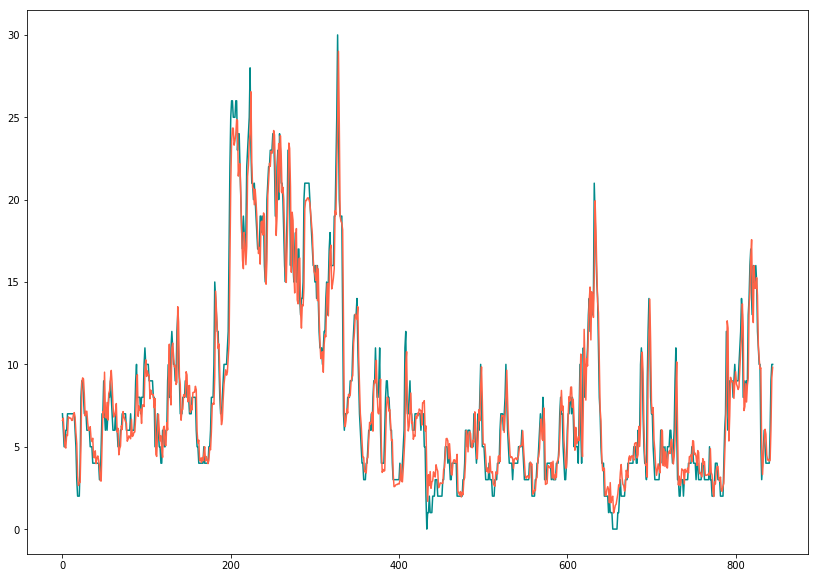

2.1864076
1465.167


In [25]:
fig = plt.figure(figsize=(14, 10))
plt.plot(y_test_set[:,0,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()

print(loss_fn(one_step_predictions,y_test_set[:,0,-1]).data.numpy())
print(loss.data.numpy())

## 24hours model